In [1]:
# !pip install pandas
# !pip install gensim
# !pip install nltk
# !pip install sklearn
# !pip install numpy
# !pip install openpyxl
# !pip install scipy
# !pip install textblob
# !pip install wordcloud
# !pip install textblob
# !pip install seaborn

In [2]:
import pickle
import pandas as pd
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from textblob import TextBlob

from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
import oc

from scipy.sparse import hstack

import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import warnings
warnings.simplefilter('ignore')

RANDOM_SEED = 42

# Data Cleaning

With our text data, we are going to apply some of the text pre-processing techniques. Since this cleaning process can go on forever. There's always an exception to every cleaning steps. So, we're going to do this process in a few rounds.

**Below are the steps we will be applying to our dataset:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words
* Stemming & Lemmatization


In [3]:
def clean_up(df):

    def clean_text(text):
        text = text.lower()
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = re.sub('[‘’“”—…]', '', text)
        text = re.sub('\n', '', text)
        return text

    def lemmatize_text(text):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(w) for w in text]

    data_clean = pd.DataFrame(df.apply(lambda x: clean_text(x)))

    stop_words = stopwords.words('english')
    data_clean = data_clean.iloc[:,0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    data_clean = data_clean.apply(lambda x: x.encode('ascii', 'ignore').decode("ascii","ignore"))
    data_clean = data_clean.apply(lambda y: [x for x in word_tokenize(y)])
    data_clean = data_clean.apply(lemmatize_text)


    data_clean = pd.DataFrame(data_clean)

    return data_clean



### Cleaning data from DeepBlue for Bias Model

In [4]:
data_bias=pd.read_csv('assets/pb_budak_v2.csv')
data_bias=data_bias[['title','text','democrat.vote','republican.vote',]]
data_bias = data_bias.dropna().reset_index(drop=True)
data_bias = data_bias.rename(columns={'democrat.vote':'democrat','republican.vote':'republican','text':'article'})
data_bias['democrat'] = data_bias['democrat'].replace({'Negative':4,'SomewhatNegative':3,'Neutral':2,'SomewhatPositive':1,'Positive':0}).astype('int')
data_bias['republican'] = data_bias['republican'].replace({'Negative':0,'SomewhatNegative':1,'Neutral':2,'SomewhatPositive':3,'Positive':4}).astype('int')
data_bias['type'] = data_bias[['democrat', 'republican']].mean(axis=1)

data_bias_cleanned = clean_up(data_bias['article'])
data_bias['tokens'] = data_bias_cleanned['article']
data_bias

,title,article,democrat,republican,type,tokens
0,Zimmerman verdict renews focus on 'stand your ...,Maggie Clark\n\nPew/Stateline Staff Writer\n\n...,2,2,2.0,"[maggie, clarkpewstateline, staff, writer, sta..."
1,Senate Immigration Bill Passes Out Of Judiciar...,WASHINGTON -- The Senate Judiciary Committee a...,2,2,2.0,"[washington, senate, judiciary, committee, app..."
2,Don’t let DOMA fool you — the Supreme Court is...,David Cole is a professor of constitutional la...,2,2,2.0,"[david, cole, professor, constitutional, law, ..."
3,ObamaCare in Trouble? Exchange provision delay...,NEW You can now listen to Fox News articles!\n...,2,2,2.0,"[new, listen, fox, news, articlesparts, obamac..."
4,Exclusive: Immigration Agents Rip House Lawmak...,U.S. Immigration Citizenship and Immigration S...,2,2,2.0,"[u, immigration, citizenship, immigration, ser..."
...,...,...,...,...,...,...
15835,Dana Milbank: Senators turn the tables on Caym...,President Obama won reelection in part by beat...,1,1,1.0,"[president, obama, reelection, part, beating, ..."
15836,Republicans’ Hatred of Obama Blinds Them to Pu...,"Red-faced Republicans, circling and preparing ...",1,1,1.0,"[redfaced, republican, circling, preparing, po..."
15837,Dana Milbank: Stockman steps forward as Republ...,Rep. Steve Stockman’s moment as a viable Senat...,2,2,2.0,"[rep, steve, stockman, moment, viable, senate,..."
15838,E.J. Dionne: When Republicans were problem-sol...,We interrupt this highly partisan and ideologi...,1,1,1.0,"[interrupt, highly, partisan, ideological, mom..."


### EDA (Sentiment analysis + Wordcloud)

**Sentiment Analysis**
* TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment, we will apply this to our dataset to see if each political position has different sentiment scores
* Find out if sentiment score can be used for further analysis (as a new variable to the model)




In [5]:
# TextBlob’s Sentiment() function requires a string
data_bias['tokens_str'] = [' '.join(map(str,l)) for l in data_bias['tokens']]

#apply TextBlob for sentiment analysis
data_bias['sentiment'] = data_bias['tokens_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

data_bias['word_count'] = data_bias['tokens'].apply(lambda x: len(str(x).split()))

data_bias['article_len'] = data_bias['tokens_str'].astype(str).apply(len)

data_bias.head()

,title,article,democrat,republican,type,tokens,tokens_str,sentiment,word_count,article_len
0,Zimmerman verdict renews focus on 'stand your ...,Maggie Clark\n\nPew/Stateline Staff Writer\n\n...,2,2,2.0,"[maggie, clarkpewstateline, staff, writer, sta...",maggie clarkpewstateline staff writer state la...,0.079039,389,2885
1,Senate Immigration Bill Passes Out Of Judiciar...,WASHINGTON -- The Senate Judiciary Committee a...,2,2,2.0,"[washington, senate, judiciary, committee, app...",washington senate judiciary committee approved...,0.060037,620,4565
2,Don’t let DOMA fool you — the Supreme Court is...,David Cole is a professor of constitutional la...,2,2,2.0,"[david, cole, professor, constitutional, law, ...",david cole professor constitutional law crimin...,0.067142,810,6555
3,ObamaCare in Trouble? Exchange provision delay...,NEW You can now listen to Fox News articles!\n...,2,2,2.0,"[new, listen, fox, news, articlesparts, obamac...",new listen fox news articlesparts obamacare st...,0.002922,423,3053
4,Exclusive: Immigration Agents Rip House Lawmak...,U.S. Immigration Citizenship and Immigration S...,2,2,2.0,"[u, immigration, citizenship, immigration, ser...",u immigration citizenship immigration service ...,-0.045192,556,4300


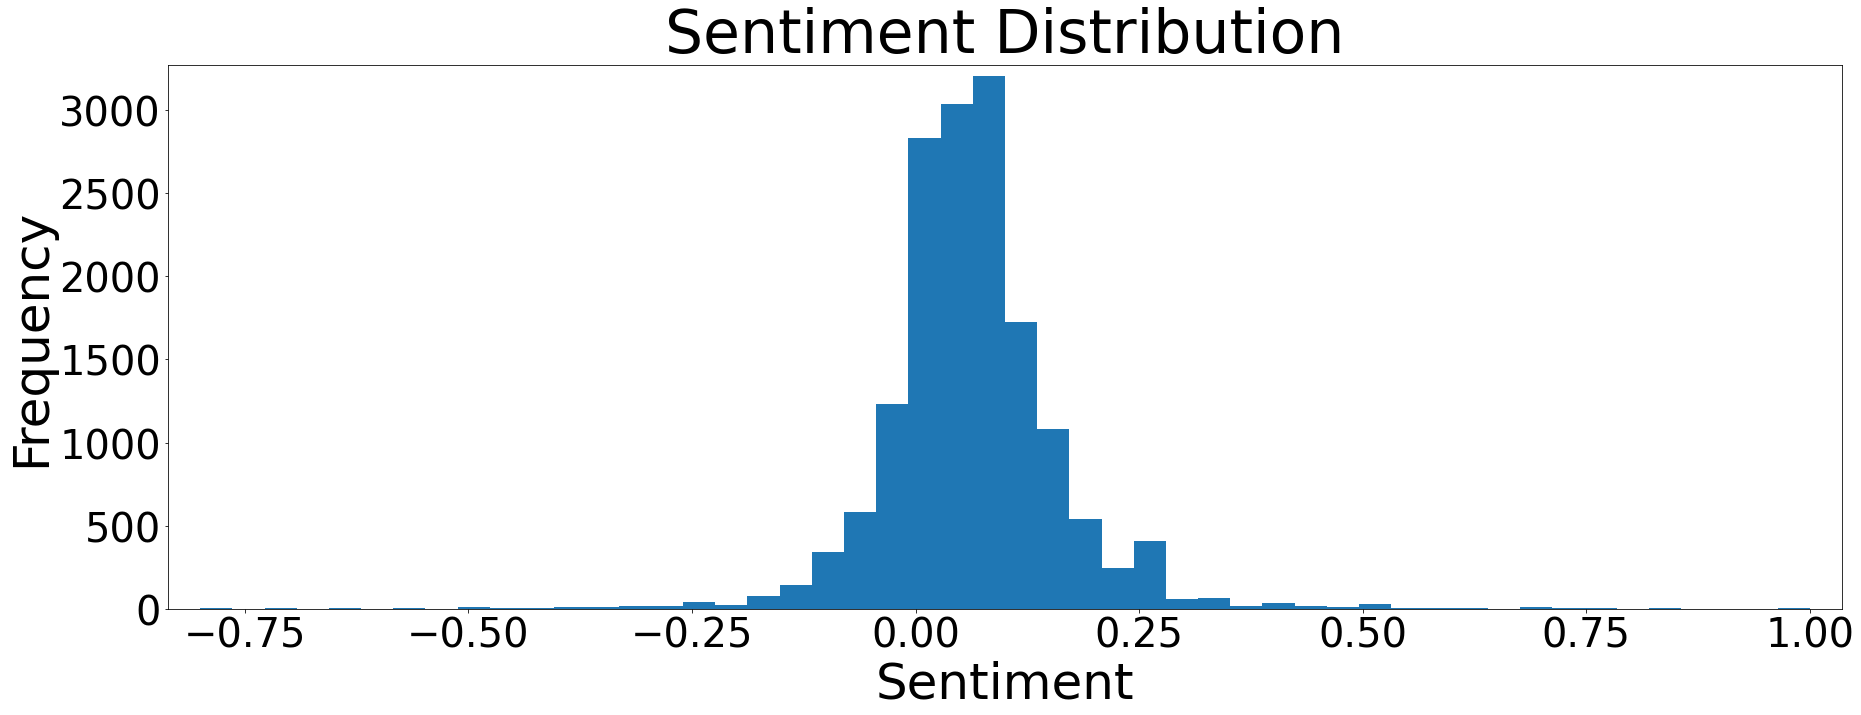

In [6]:
plt.figure(figsize=(30,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(data_bias['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

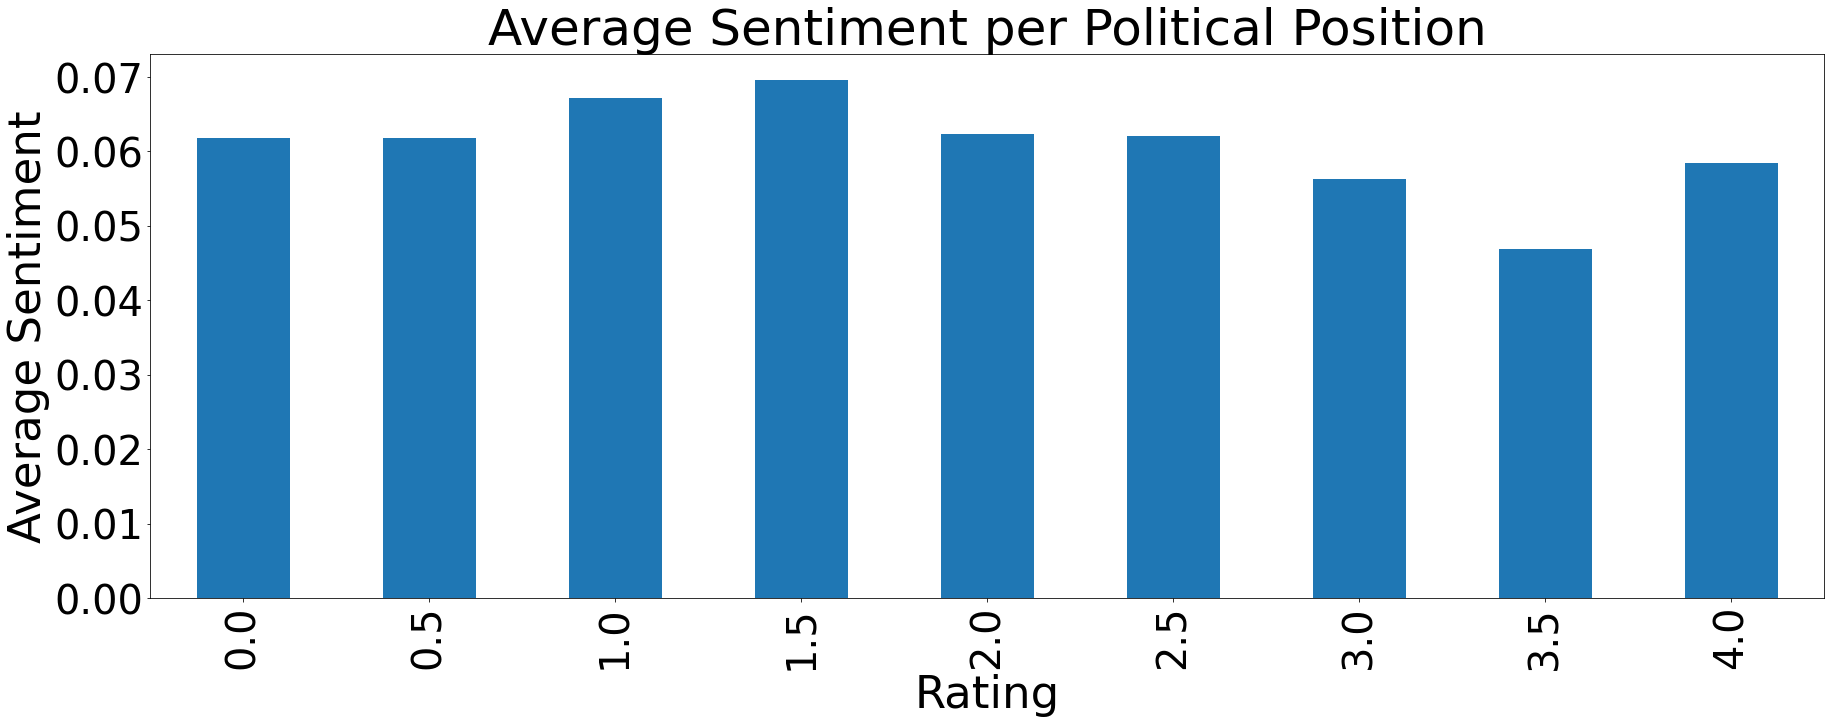

In [7]:
polarity_avg = data_bias.groupby('type')['sentiment'].mean().plot(kind='bar', figsize=(30,10))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Political Position', fontsize=50)
plt.show()

<AxesSubplot:>

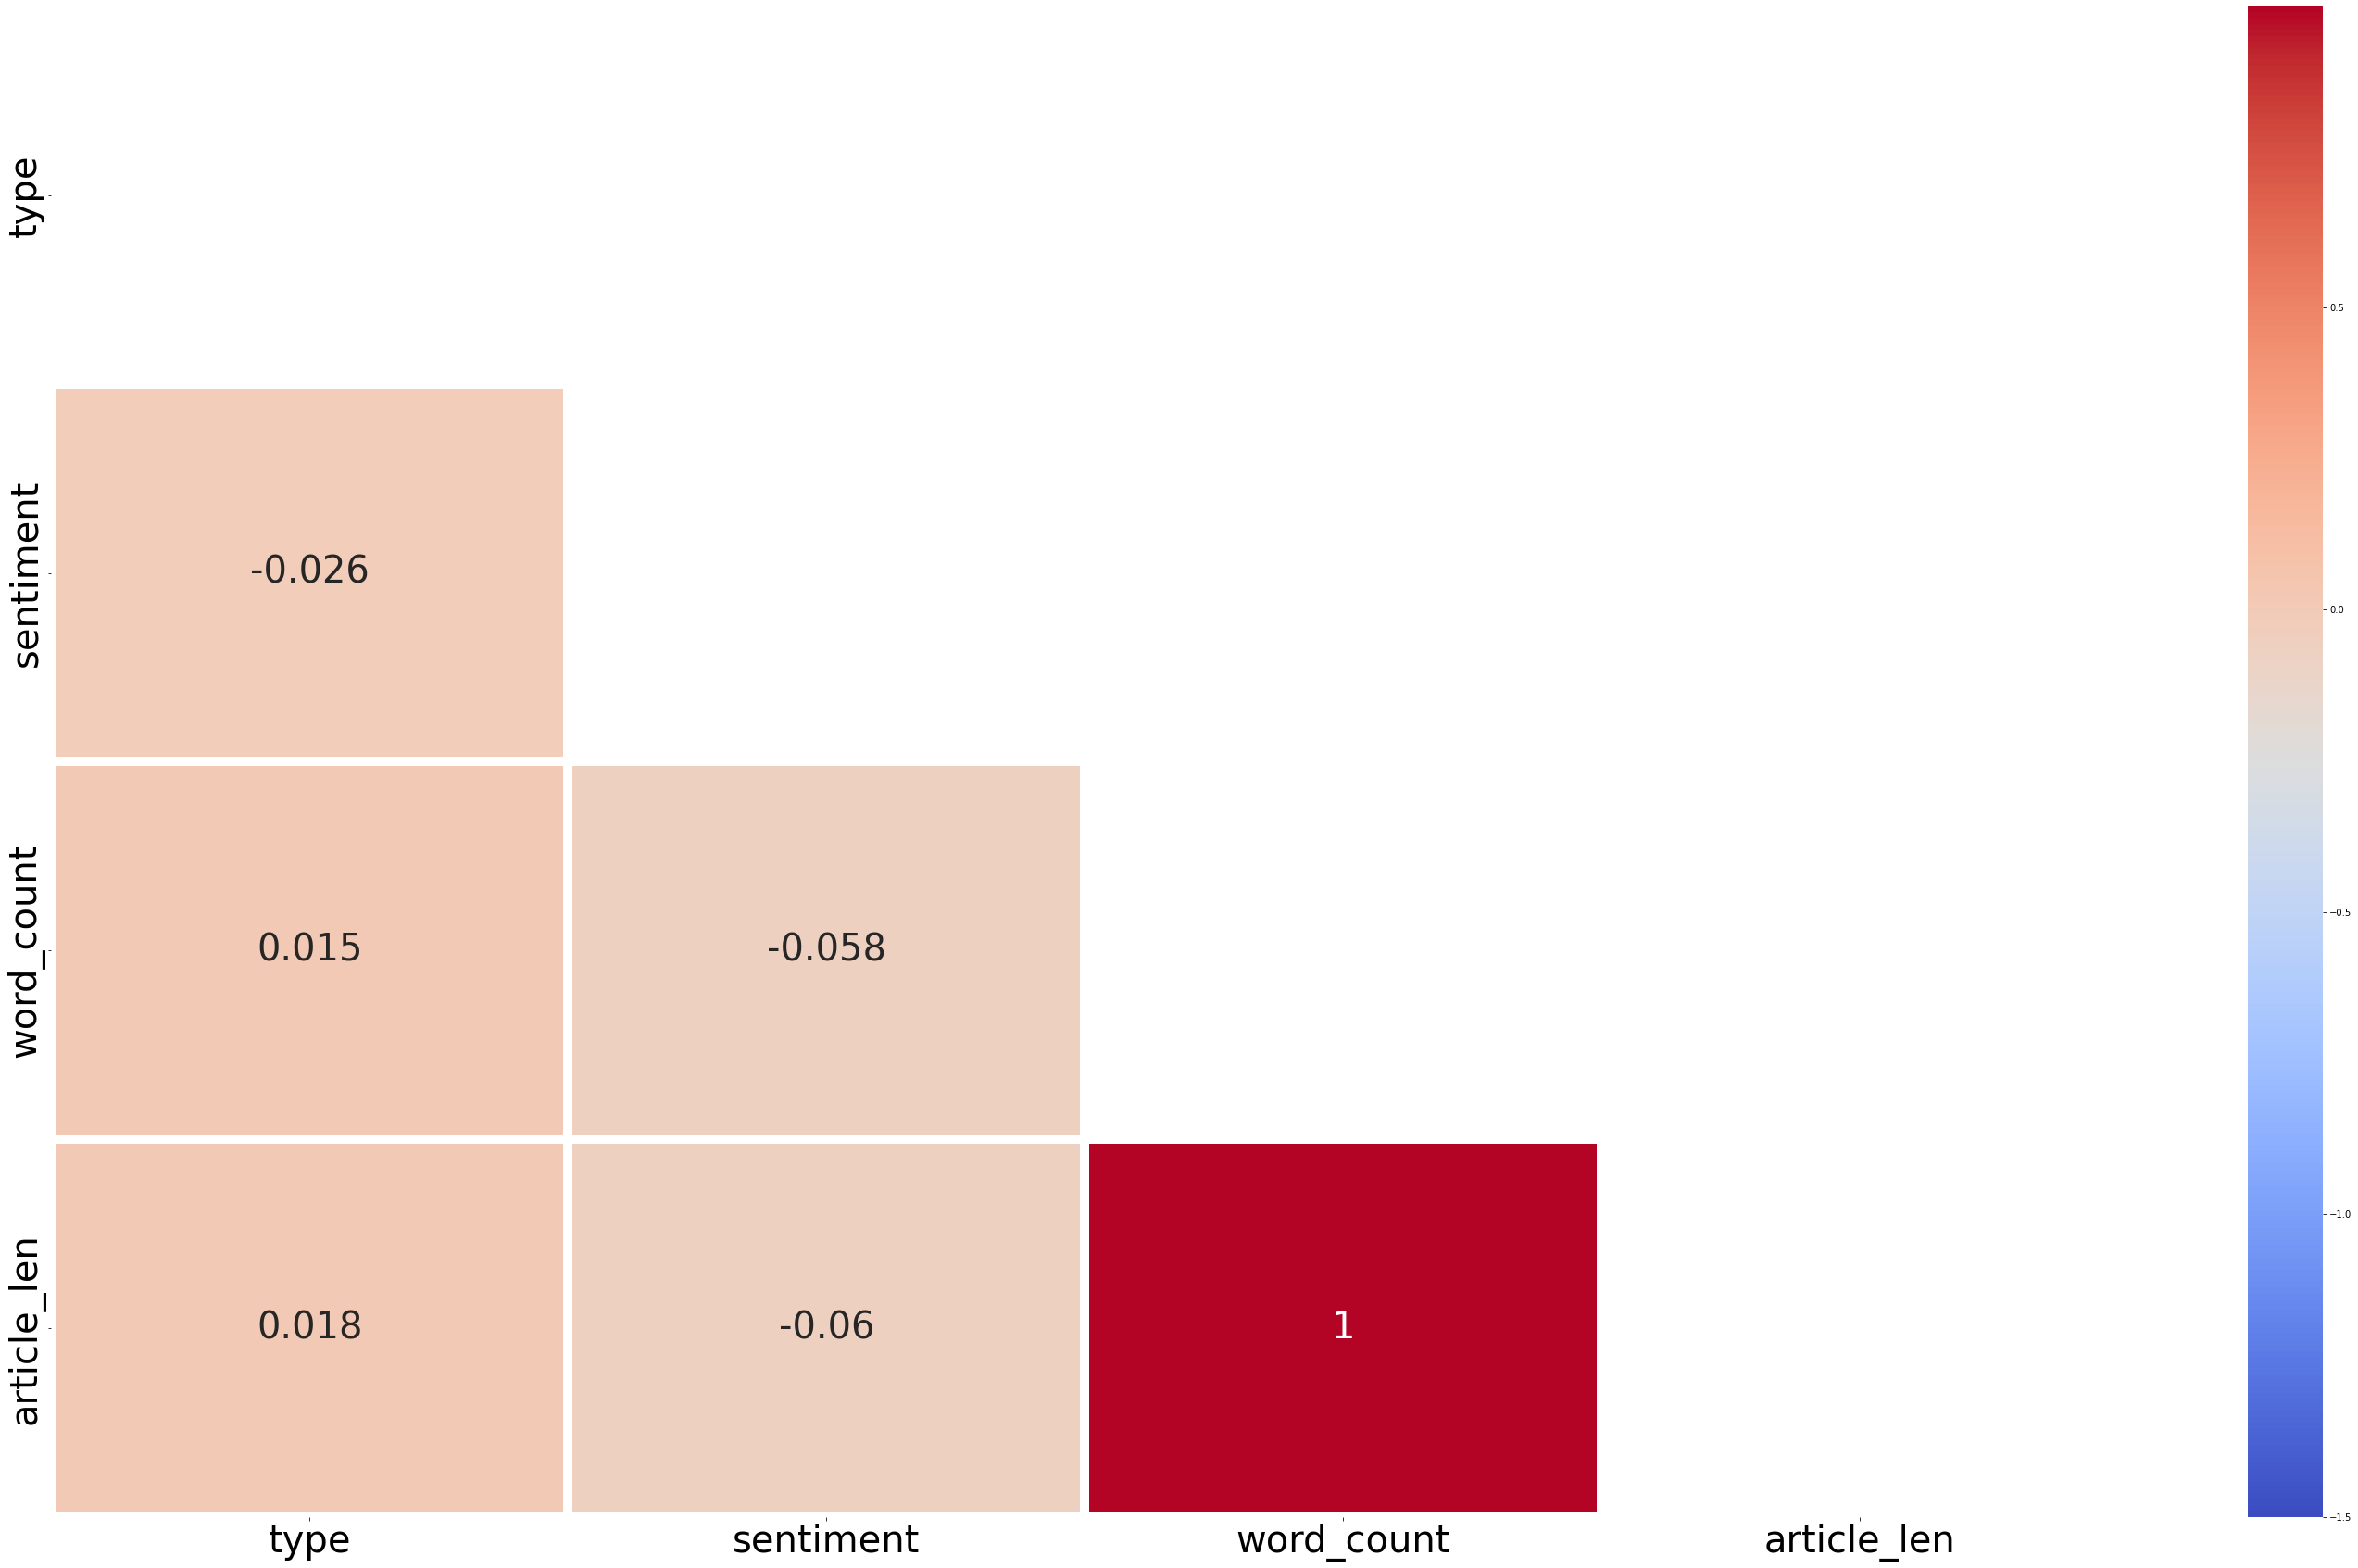

In [8]:
correlation = data_bias[['type','sentiment','word_count','article_len']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

* We can see from a histogram of our sentiment that the vast majority of it falls between -0.1 and 0.2 indicating that the general attitude is “neutral” toward each political position is very similar. Also, the sentiment score does not seem to have correlation with political position, we decided not to used it as a variable for further analysis.

**Wordcloud**
* Apply wordcloud to visualize the most 50 common word from each political position
* Also oversee high frequency words in the corpus to see if any of them can be removed to further clean the dataset (ie. add them to our stopwords) prior to analysis

In [9]:

def wordcloud_plot(items_list,title):
    words = []
    for wordList in items_list:
        words += wordList
    common_wds = FreqDist(words).most_common(50)
    cloud = WordCloud(width=1000, height=400, background_color='white').generate(str(common_wds))
    plt.figure(figsize=(15,6), facecolor='white')
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=40)
    plt.tight_layout(pad=0)
    final_plot = plt.show
    return final_plot


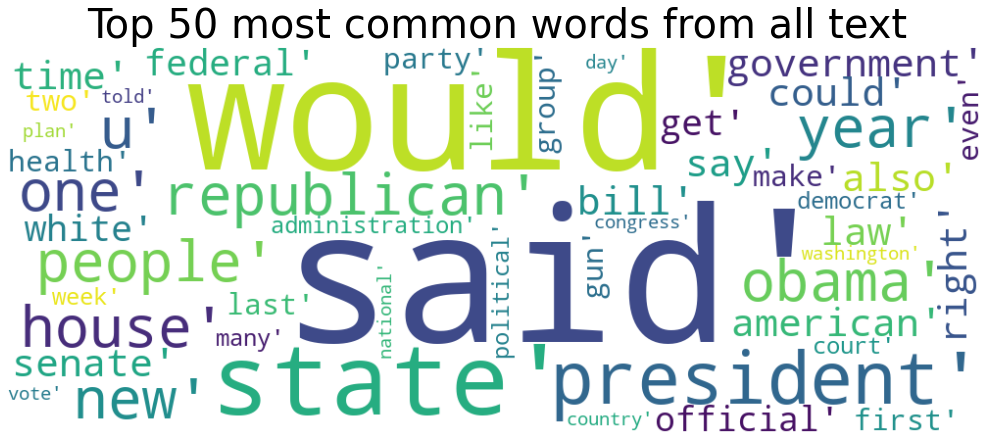

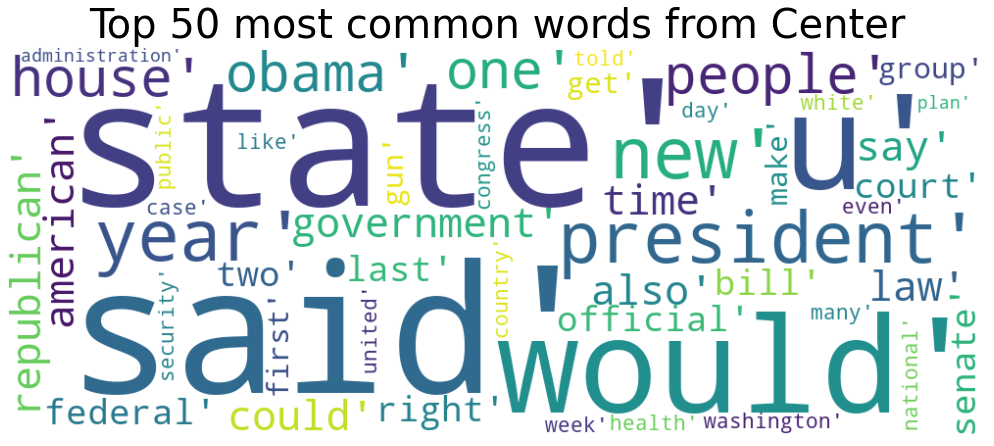

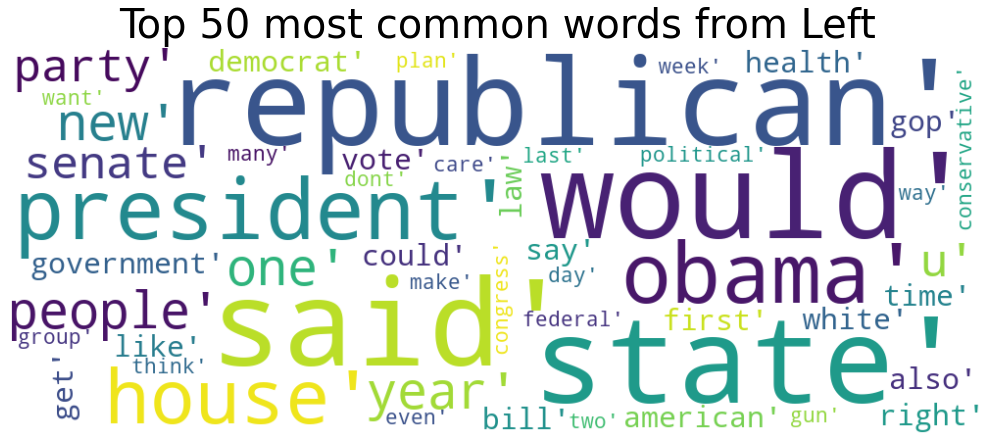

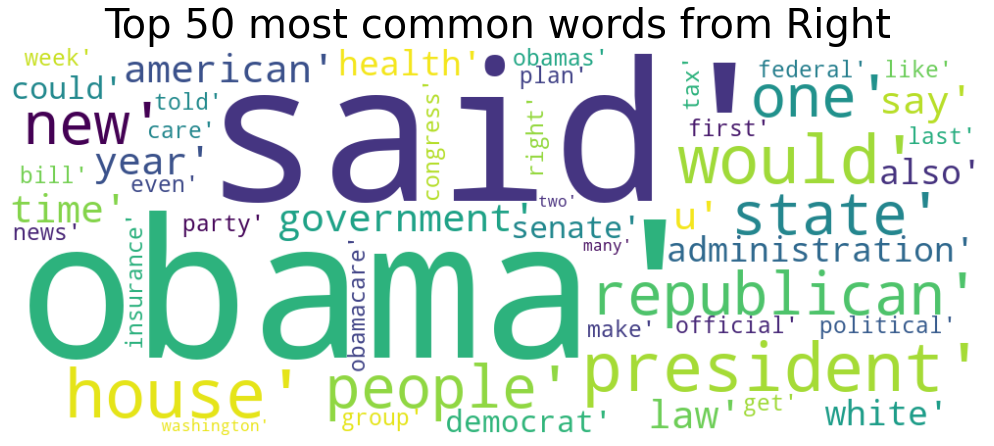

In [10]:
all_wd    = data_bias['tokens']
center_wd = data_bias.loc[data_bias["type"] == 2, "tokens"]
left_wd   = data_bias.loc[data_bias["type"] < 2, "tokens"]
right_wd  = data_bias.loc[data_bias["type"] > 2, "tokens"]
lists = [all_wd, center_wd, left_wd, right_wd]
title = ['Top 50 most common words from all text',
         'Top 50 most common words from Center',
         'Top 50 most common words from Left',
         'Top 50 most common words from Right']

for i,j in zip(lists,title):
    wordcloud_plot(i,j)


In [11]:
def wordcloud_chart(items_list):
    words = []
    for wordList in items_list:
        words += wordList
    mostcommon_small = FreqDist(words).most_common(50)
    x, y = zip(*mostcommon_small)
    plt.figure(figsize=(60,40))
    plt.margins(0.02)
    plt.bar(x, y)
    plt.xlabel('Words', fontsize=60)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=50)
    plt.xticks(rotation=90, fontsize=60)
    plt.title('Frequency of 50 Most Common Words', fontsize=60)
    plt.tight_layout()
    return plt.show()

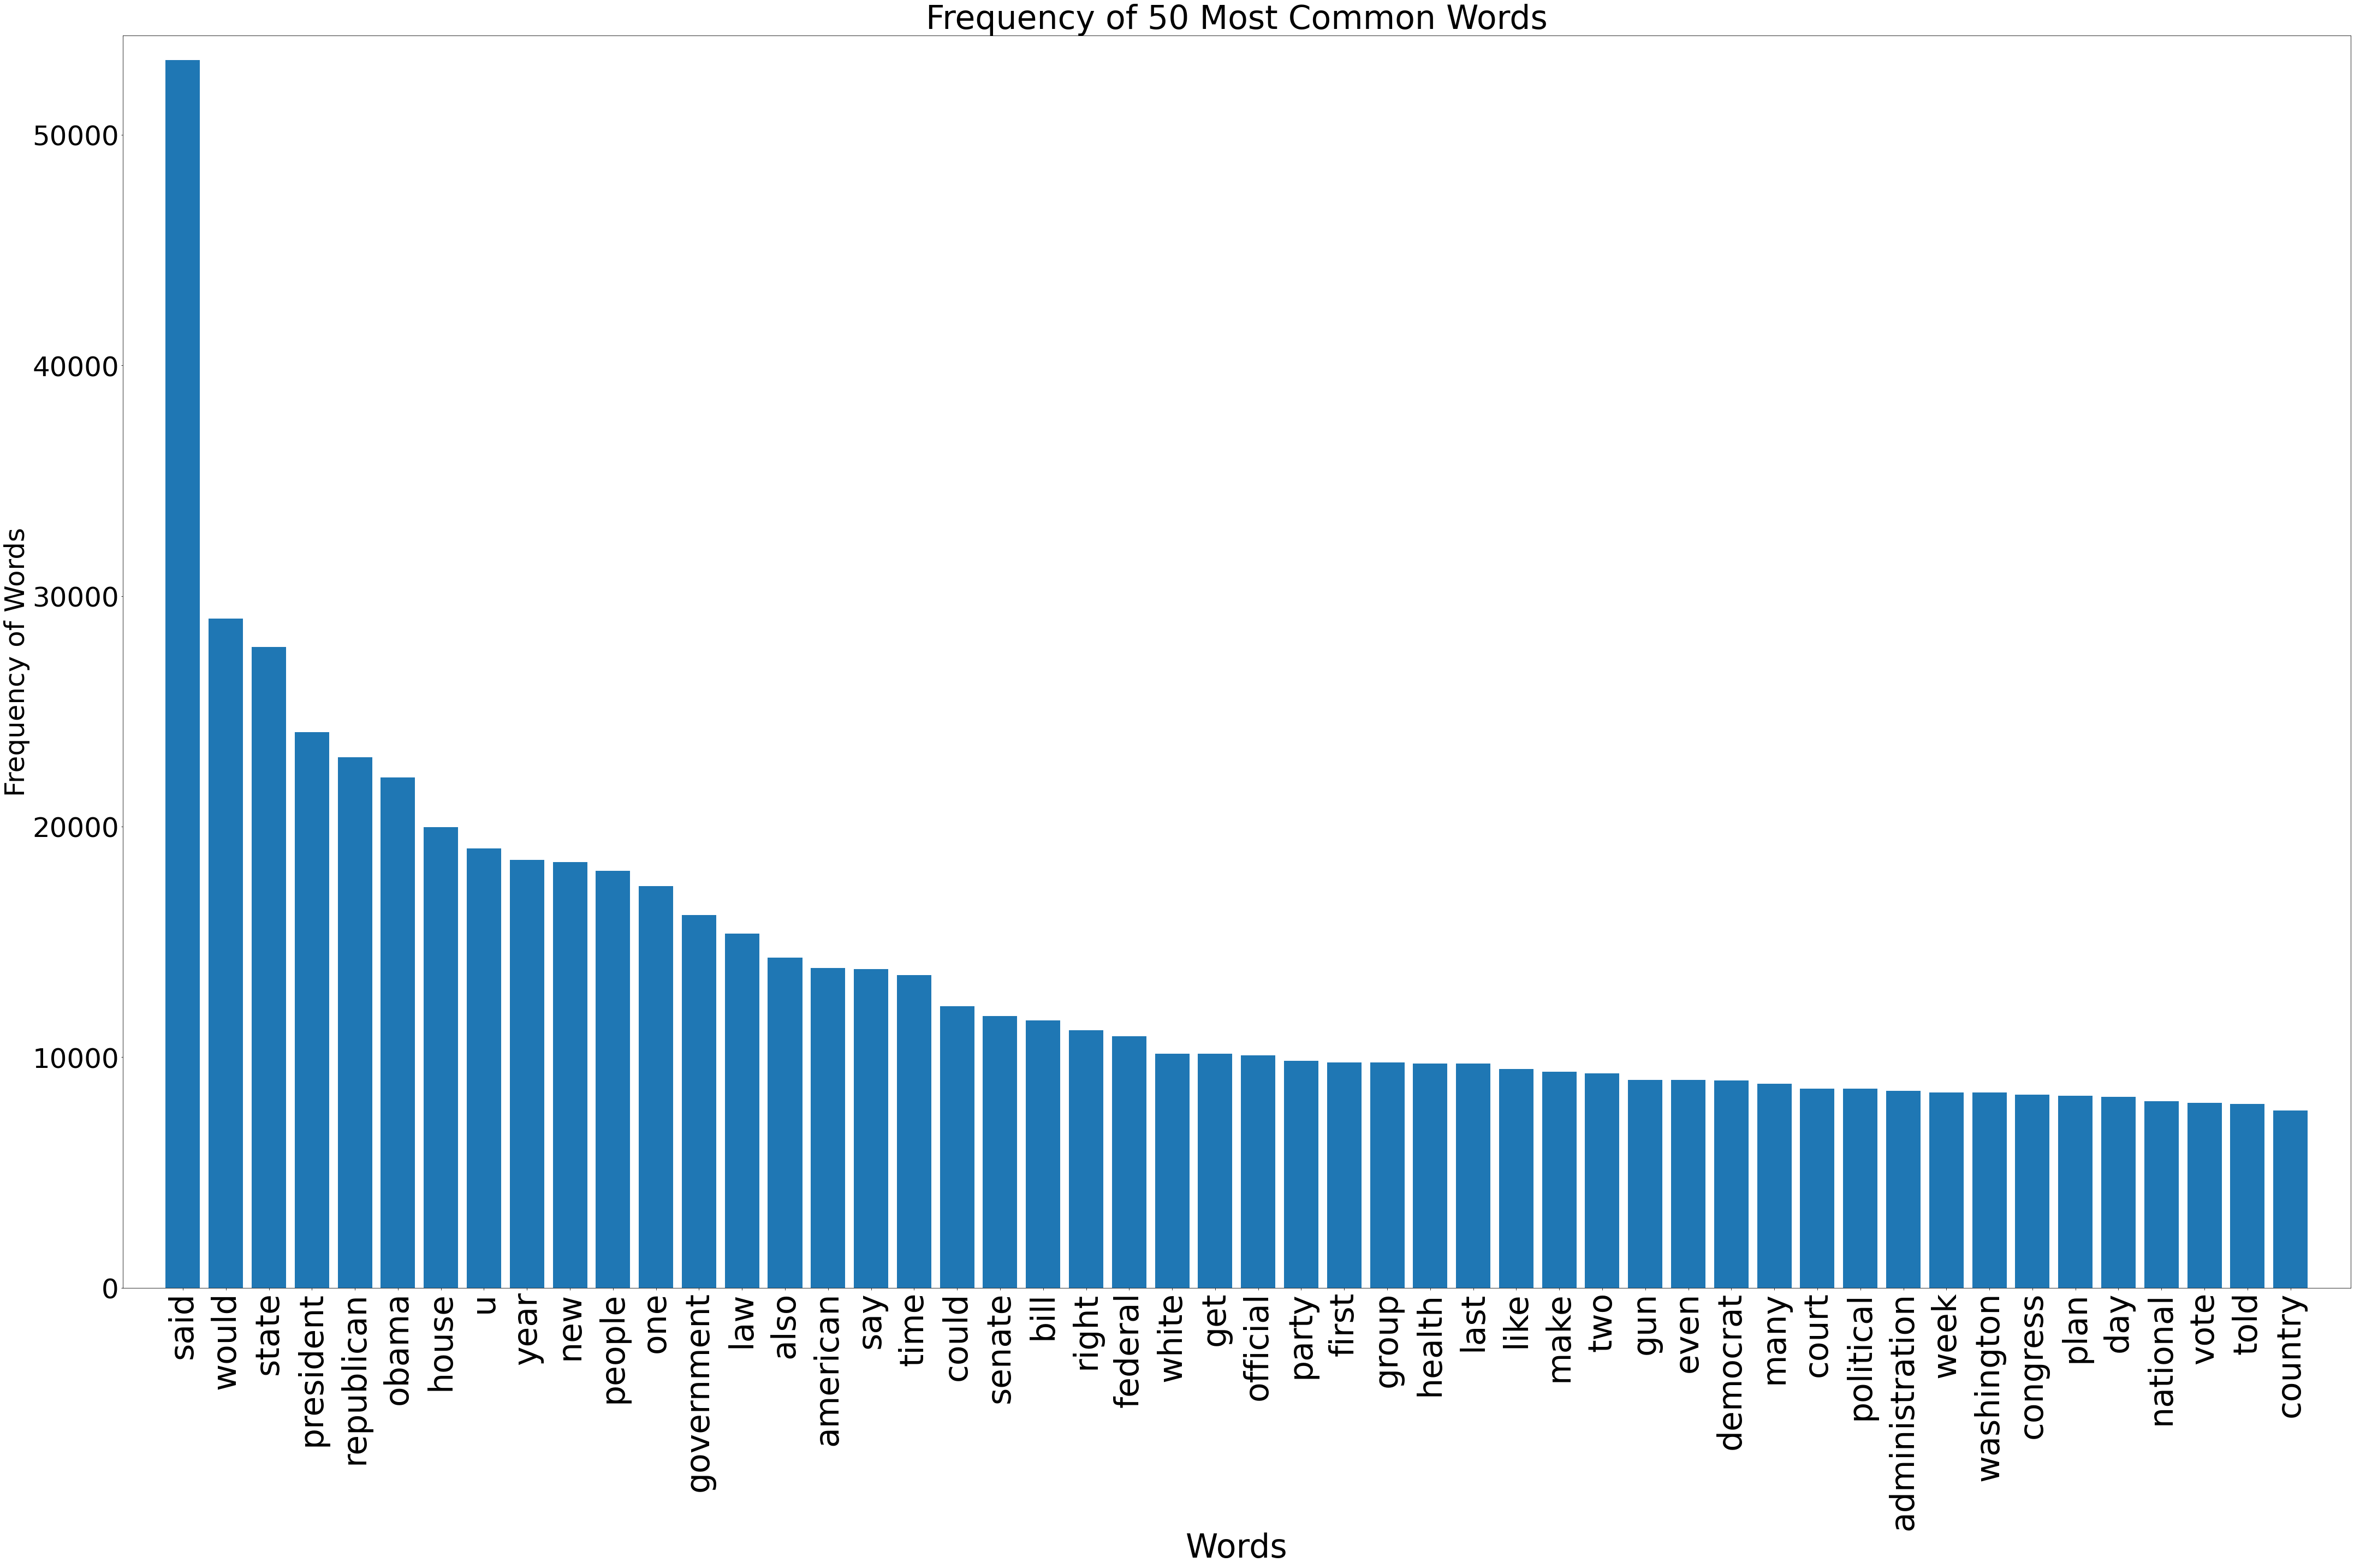

In [12]:
wordcloud_chart(all_wd)

**Based on the words' frequency above, we can see words such as:**
* **"said","would", "u", "also", "even", "could", "may"**  - each of them has frequency around 2,000, can be added to stopword list

In [13]:
stop_words = stopwords.words('english')
new_words = ["said","would", "u", "also", "even", "could", "may"]
stop_words.extend(new_words)

data_bias['tokens'] = data_bias['tokens'].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))
data_bias['tokens'] = data_bias.tokens.apply(lambda y: [x for x in word_tokenize(y)])

data_bias

,title,article,democrat,republican,type,tokens,tokens_str,sentiment,word_count,article_len
0,Zimmerman verdict renews focus on 'stand your ...,Maggie Clark\n\nPew/Stateline Staff Writer\n\n...,2,2,2.0,"[maggie, clarkpewstateline, staff, writer, sta...",maggie clarkpewstateline staff writer state la...,0.079039,389,2885
1,Senate Immigration Bill Passes Out Of Judiciar...,WASHINGTON -- The Senate Judiciary Committee a...,2,2,2.0,"[washington, senate, judiciary, committee, app...",washington senate judiciary committee approved...,0.060037,620,4565
2,Don’t let DOMA fool you — the Supreme Court is...,David Cole is a professor of constitutional la...,2,2,2.0,"[david, cole, professor, constitutional, law, ...",david cole professor constitutional law crimin...,0.067142,810,6555
3,ObamaCare in Trouble? Exchange provision delay...,NEW You can now listen to Fox News articles!\n...,2,2,2.0,"[new, listen, fox, news, articlesparts, obamac...",new listen fox news articlesparts obamacare st...,0.002922,423,3053
4,Exclusive: Immigration Agents Rip House Lawmak...,U.S. Immigration Citizenship and Immigration S...,2,2,2.0,"[immigration, citizenship, immigration, servic...",u immigration citizenship immigration service ...,-0.045192,556,4300
...,...,...,...,...,...,...,...,...,...,...
15835,Dana Milbank: Senators turn the tables on Caym...,President Obama won reelection in part by beat...,1,1,1.0,"[president, obama, reelection, part, beating, ...",president obama reelection part beating oppone...,0.186042,405,2986
15836,Republicans’ Hatred of Obama Blinds Them to Pu...,"Red-faced Republicans, circling and preparing ...",1,1,1.0,"[redfaced, republican, circling, preparing, po...",redfaced republican circling preparing pounce ...,0.010294,430,3187
15837,Dana Milbank: Stockman steps forward as Republ...,Rep. Steve Stockman’s moment as a viable Senat...,2,2,2.0,"[rep, steve, stockman, moment, viable, senate,...",rep steve stockman moment viable senate candid...,0.120066,521,4016
15838,E.J. Dionne: When Republicans were problem-sol...,We interrupt this highly partisan and ideologi...,1,1,1.0,"[interrupt, highly, partisan, ideological, mom...",interrupt highly partisan ideological moment c...,0.137436,413,3201


In [14]:
data_bias.to_csv('assets/pb_budak_v3.csv')

## Part 1a: Political Bias Modeling

First we want to build a model of political bias using features that will be available in our primary dataset. We'll import the Spinde political bias dataset and select the article text and bias rating columns. Then, we'll vectorize the article text and train the model.

In [15]:
pb_reduced = data_bias.copy()
pb_reduced

,title,article,democrat,republican,type,tokens,tokens_str,sentiment,word_count,article_len
0,Zimmerman verdict renews focus on 'stand your ...,Maggie Clark\n\nPew/Stateline Staff Writer\n\n...,2,2,2.0,"[maggie, clarkpewstateline, staff, writer, sta...",maggie clarkpewstateline staff writer state la...,0.079039,389,2885
1,Senate Immigration Bill Passes Out Of Judiciar...,WASHINGTON -- The Senate Judiciary Committee a...,2,2,2.0,"[washington, senate, judiciary, committee, app...",washington senate judiciary committee approved...,0.060037,620,4565
2,Don’t let DOMA fool you — the Supreme Court is...,David Cole is a professor of constitutional la...,2,2,2.0,"[david, cole, professor, constitutional, law, ...",david cole professor constitutional law crimin...,0.067142,810,6555
3,ObamaCare in Trouble? Exchange provision delay...,NEW You can now listen to Fox News articles!\n...,2,2,2.0,"[new, listen, fox, news, articlesparts, obamac...",new listen fox news articlesparts obamacare st...,0.002922,423,3053
4,Exclusive: Immigration Agents Rip House Lawmak...,U.S. Immigration Citizenship and Immigration S...,2,2,2.0,"[immigration, citizenship, immigration, servic...",u immigration citizenship immigration service ...,-0.045192,556,4300
...,...,...,...,...,...,...,...,...,...,...
15835,Dana Milbank: Senators turn the tables on Caym...,President Obama won reelection in part by beat...,1,1,1.0,"[president, obama, reelection, part, beating, ...",president obama reelection part beating oppone...,0.186042,405,2986
15836,Republicans’ Hatred of Obama Blinds Them to Pu...,"Red-faced Republicans, circling and preparing ...",1,1,1.0,"[redfaced, republican, circling, preparing, po...",redfaced republican circling preparing pounce ...,0.010294,430,3187
15837,Dana Milbank: Stockman steps forward as Republ...,Rep. Steve Stockman’s moment as a viable Senat...,2,2,2.0,"[rep, steve, stockman, moment, viable, senate,...",rep steve stockman moment viable senate candid...,0.120066,521,4016
15838,E.J. Dionne: When Republicans were problem-sol...,We interrupt this highly partisan and ideologi...,1,1,1.0,"[interrupt, highly, partisan, ideological, mom...",interrupt highly partisan ideological moment c...,0.137436,413,3201


In [16]:
#Now we'll train the Word2Vec model on our text tokens.
wv_mod = Word2Vec(pb_reduced['tokens'], seed = RANDOM_SEED)
wv_mod.save("assets/pb_w2v_model.pkl") # models/pb_classifier_model.pkl
#We'll extract the vectors from the model...
vectors = wv_mod.wv
#...and since each word is a vector of 100 numbers, we'll take the mean of all word vectors in a given article 
#to represent the article as a whole
vec_frame = pd.DataFrame([vectors.get_mean_vector(x) for x in pb_reduced.tokens])

In [17]:
##This is an alternate vectorization, if we wanted to do TF-IDF. We'll not use it here because it didn't really impact performance, but we'll use it for the fake news portion.
# vec = TfidfVectorizer(strip_accents='ascii',stop_words='english',ngram_range=(1,2))
# vec_frame = vec.fit_transform(pb_reduced.article)
# vec_frame

In [18]:
#Finally, we'll train a Random Forest classifier on the vectorized text to predict article bias.
pb_reduced['type'] = pb_reduced['type'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(vec_frame, pb_reduced.type, test_size=0.2, random_state=RANDOM_SEED)

In [19]:
clf = oc.OrdClass(RandomForestClassifier,clf_args={'min_samples_split':100, 'min_samples_leaf':50, 'random_state':RANDOM_SEED})
clf.fit(X_train, y_train)
filename = "assets/pb_classifier_model.pkl" #models/pb_classifier_model.pkl
pickle.dump(clf, open(filename, 'wb'))

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7236426767676768
0.7228535353535354


### Cleaning Data from Kaggle

In [20]:
#This was the old fake news dataset; I'll leave the line in for archiving purposes but we've switched to the new one below.
#data_news=pd.read_csv('assets/fn_kagg_train.csv') #assets/fn_kagg_train.csv

##Note: sklearn's TF-IDF vectorizor automatically does stemming and tokenization and I can't get it to work on pre-tokenized text, so we won't actually be using these here. 
#However, I'll leave this in for now
data_news=pd.read_csv('assets/Misinformation_detection-master/buzzfeed_labeled_no_title_v02.csv')
data_news = data_news.dropna().reset_index(drop=True)
data_news = data_news[data_news['label']!='nofact']
data_news['label'] = data_news['label'].replace({'mtrue':0,'mixture':1,'mfalse':2}).astype('int')
data_text_cleaned = clean_up(data_news['text'])
data_news['text_tokens'] = data_text_cleaned['text']
data_news = data_news[['text','text_tokens','label']]
data_news

,text,text_tokens,label
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0
...,...,...,...
1375,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0
1376,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1
1377,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0
1378,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0


## Part 1b: Applying the Model

Now, we want to predict the political bias of the target fake news dataset. We'll save these predictions as probabilities, which we'll use as additional features for clustering and trustworthiness prediction.

In [21]:
fn_kag_tok = data_news.copy()
##Removing the article length requirement, as Ray suggested
# fn_kag_tok['tmp'] = fn_kag_tok['text_tokens'].apply(lambda x: len(x))
# fn_kag_tok = fn_kag_tok[fn_kag_tok['tmp']>30]
# fn_kag_tok = fn_kag_tok.drop(columns='tmp').reset_index(drop=True)
fn_kag_tok

,text,text_tokens,label
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0
...,...,...,...
1375,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0
1376,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1
1377,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0
1378,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0


In [22]:
#Now we'll apply the Word2Vec model we generated above to our tokens to vectorize the text.
vec_frame = pd.DataFrame([vectors.get_mean_vector(x) for x in fn_kag_tok.text_tokens])

In [23]:
#Now we apply the Random Forest classifier to our vectorized text and save out the predicted probabilities.
preds = pd.DataFrame(clf.predict_proba(vec_frame), columns=['pb_vLeft','pb_Left','pb_Neu','pb_Right','pb_vRight'])
preds

,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight
0,0.000102,0.058263,0.917039,0.024596,0.000000
1,0.020600,0.197261,0.688295,0.092837,0.001007
2,0.021742,0.323494,0.519163,0.133200,0.002400
3,0.000277,0.074029,0.922250,0.003444,0.000000
4,0.001190,0.071361,0.909534,0.016895,0.001020
...,...,...,...,...,...
1319,0.004567,0.104054,0.845895,0.044479,0.001004
1320,0.006998,0.153731,0.719757,0.117707,0.001806
1321,0.006367,0.059806,0.896309,0.035792,0.001726
1322,0.029551,0.247478,0.644167,0.075884,0.002920


In [24]:
#Finally, we'll rejoin the predictions to the original dataset.
fn_kag_reduced = fn_kag_tok.copy().reset_index(drop=True)
fn_kag_reduced = fn_kag_reduced.join(preds)
fn_kag_reduced

,text,text_tokens,label,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0,0.000102,0.058263,0.917039,0.024596,0.000000
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0,0.020600,0.197261,0.688295,0.092837,0.001007
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0,0.021742,0.323494,0.519163,0.133200,0.002400
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0,0.000277,0.074029,0.922250,0.003444,0.000000
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0,0.001190,0.071361,0.909534,0.016895,0.001020
...,...,...,...,...,...,...,...,...
1319,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0,0.004567,0.104054,0.845895,0.044479,0.001004
1320,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1,0.006998,0.153731,0.719757,0.117707,0.001806
1321,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0,0.006367,0.059806,0.896309,0.035792,0.001726
1322,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0,0.029551,0.247478,0.644167,0.075884,0.002920


## Part 2: Clustering
Once we have all the features we want, we'll do unsupervised clustering. Ideally we'd want to do some evaluations to find an ideal number of clusters, but for now we'll just go with 4.

We'll need to re-vectorize the text, as the political bias vectors won't work here. Also, we'd probably want to vectorize both headline and article body, but for now I'll just vectorize the article body.

In [25]:
#From this point on, we should be concerned with data leakage. Everything prior to now could in theory be applied to live data. We'll go ahead and split the data out into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(fn_kag_reduced.drop(columns=['label']), fn_kag_reduced.label, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train

,text,text_tokens,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight
0,A Louisiana deputy city marshal is in hot wate...,"[louisiana, deputy, city, marshal, hot, water,...",0.009049,0.045975,0.932306,0.011035,0.001636
1,President Barack Obama listens to Prime Minist...,"[president, barack, obama, listens, prime, min...",0.005010,0.192351,0.764603,0.034559,0.003477
2,She?s on a warpath right now andit tearing up ...,"[shes, warpath, right, andit, tearing, twitter...",0.021998,0.232762,0.633578,0.108849,0.002813
3,Story highlights Jeb Bush poked fun at himself...,"[story, highlight, jeb, bush, poked, fun, emmy...",0.033028,0.283592,0.641599,0.037703,0.004079
4,Story highlights It's an honorific Knight has ...,"[story, highlight, honorific, knight, quick, u...",0.027379,0.290424,0.639083,0.037336,0.005779
...,...,...,...,...,...,...,...
1054,MikePence camp distanced itself from Vincent C...,"[mikepence, camp, distanced, vincent, caldara,...",0.000595,0.053487,0.915633,0.030141,0.000145
1055,Democratic National Committee interim Chairwom...,"[democratic, national, committee, interim, cha...",0.034240,0.330142,0.533623,0.096120,0.005875
1056,If You Want The Truth About Whose ?Lives Matte...,"[want, truth, whose, life, matter, need, see, ...",0.028140,0.159344,0.770935,0.036583,0.004998
1057,The show's former cast members will campaign f...,"[show, former, cast, member, campaign, hillary...",0.022260,0.299944,0.622643,0.052098,0.003054


In [26]:
##OLD CODE with W2V vectorization!
#Since we already have the tokenized text from above, we can just go ahead and train the new Word2Vec model on those tokens.
# wv_mod = Word2Vec(X_train['text_tokens'], seed = RANDOM_SEED)
# wv_mod.save("models/fn_w2v_model.pkl") #models/fn_w2v_model.pkl
# #Again we'll extract and average the word vectors.
# vectors = wv_mod.wv
# vec_frame = pd.DataFrame([vectors.get_mean_vector(x) for x in X_train.text_tokens])
# X_train_all = vec_frame.join(X_train.drop(columns=['text','text_tokens']))

In [27]:
#New code with TF-IDF vectorization.
text_vec_mod = TfidfVectorizer(strip_accents='ascii',stop_words='english',ngram_range=(1,2))
text_vecs = text_vec_mod.fit_transform(X_train.text)

filename = "assets/fn_text_tfidf_model.pkl" #models/pb_classifier_model.pkl
pickle.dump(text_vec_mod, open(filename, 'wb'))

#We'll join the new word vectors with the bias estimates we generate above.
X_train_sparse = hstack((text_vecs,X_train.drop(columns=['text','text_tokens'])))
X_train_sparse

<1059x248212 sparse matrix of type '<class 'numpy.float64'>'
	with 512876 stored elements in COOrdinate format>

In [28]:
#Finally we'll build our clustering model...
cls = KMeans(3, random_state=RANDOM_SEED).fit(X_train_sparse)
filename = "assets/cluster_mod.pkl"
pickle.dump(cls, open(filename, 'wb'))

In [29]:
#...and add the predicted clusters back into the vector dataframe.
X_train['cluster'] = cls.predict(X_train_sparse)
X_train_sparse = hstack((X_train_sparse,pd.DataFrame(X_train['cluster'])))
X_train

,text,text_tokens,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight,cluster
0,A Louisiana deputy city marshal is in hot wate...,"[louisiana, deputy, city, marshal, hot, water,...",0.009049,0.045975,0.932306,0.011035,0.001636,0
1,President Barack Obama listens to Prime Minist...,"[president, barack, obama, listens, prime, min...",0.005010,0.192351,0.764603,0.034559,0.003477,1
2,She?s on a warpath right now andit tearing up ...,"[shes, warpath, right, andit, tearing, twitter...",0.021998,0.232762,0.633578,0.108849,0.002813,2
3,Story highlights Jeb Bush poked fun at himself...,"[story, highlight, jeb, bush, poked, fun, emmy...",0.033028,0.283592,0.641599,0.037703,0.004079,2
4,Story highlights It's an honorific Knight has ...,"[story, highlight, honorific, knight, quick, u...",0.027379,0.290424,0.639083,0.037336,0.005779,1
...,...,...,...,...,...,...,...,...
1054,MikePence camp distanced itself from Vincent C...,"[mikepence, camp, distanced, vincent, caldara,...",0.000595,0.053487,0.915633,0.030141,0.000145,0
1055,Democratic National Committee interim Chairwom...,"[democratic, national, committee, interim, cha...",0.034240,0.330142,0.533623,0.096120,0.005875,2
1056,If You Want The Truth About Whose ?Lives Matte...,"[want, truth, whose, life, matter, need, see, ...",0.028140,0.159344,0.770935,0.036583,0.004998,0
1057,The show's former cast members will campaign f...,"[show, former, cast, member, campaign, hillary...",0.022260,0.299944,0.622643,0.052098,0.003054,2


In [30]:
X_train_sparse

<1059x248213 sparse matrix of type '<class 'numpy.float64'>'
	with 513679 stored elements in COOrdinate format>

## Part 3: Supervised Learning

Now that we have all of our features and clusters, and article body text is already vectorized, we can train a classifier to predict whether a given article is misinformation or not.

In [31]:
##OLD CODE with W2V vectorization!
#We need to apply the vectorization and clustering from above to the test data.
# vec_frame = pd.DataFrame([vectors.get_mean_vector(x) for x in X_test.text_tokens])
# X_test_all = vec_frame.join(X_test).drop(columns=['text','text_tokens'])
# X_test_all['cluster'] = cls.predict(X_test_all)
# X_test_all

In [32]:
#New Code with TF-IDF Vectorization
test_text_vecs = text_vec_mod.transform(X_test.text)

X_test_sparse = hstack((test_text_vecs,X_test.drop(columns=['text','text_tokens'])))
X_test['cluster'] = cls.predict(X_test_sparse)
X_test_sparse = hstack((X_test_sparse,pd.DataFrame(X_test['cluster'])))

In [33]:
clf = oc.OrdClass(AdaBoostClassifier,clf_args={'random_state':RANDOM_SEED})
clf.fit(X_train_sparse, y_train)
filename = "assets/fn_classifier_model.pkl"
pickle.dump(clf, open(filename, 'wb'))

print(clf.score(X_train_sparse, y_train))
print(clf.score(X_test_sparse, y_test))

0.8611898016997167
0.8452830188679246


## Part 4: Export CSV

In [34]:
fn_export = fn_kag_reduced.copy()
fn_export

,text,text_tokens,label,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0,0.000102,0.058263,0.917039,0.024596,0.000000
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0,0.020600,0.197261,0.688295,0.092837,0.001007
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0,0.021742,0.323494,0.519163,0.133200,0.002400
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0,0.000277,0.074029,0.922250,0.003444,0.000000
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0,0.001190,0.071361,0.909534,0.016895,0.001020
...,...,...,...,...,...,...,...,...
1319,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0,0.004567,0.104054,0.845895,0.044479,0.001004
1320,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1,0.006998,0.153731,0.719757,0.117707,0.001806
1321,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0,0.006367,0.059806,0.896309,0.035792,0.001726
1322,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0,0.029551,0.247478,0.644167,0.075884,0.002920


In [36]:
export_text_vecs = text_vec_mod.transform(fn_export.text)

export_sparse = hstack((export_text_vecs,fn_export.drop(columns=['label','text','text_tokens'])))
fn_export['cluster'] = cls.predict(export_sparse)
export_sparse = hstack((export_sparse,pd.DataFrame(fn_export['cluster'])))
fn_export

,text,text_tokens,label,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight,cluster
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0,0.000102,0.058263,0.917039,0.024596,0.000000,0
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0,0.020600,0.197261,0.688295,0.092837,0.001007,1
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0,0.021742,0.323494,0.519163,0.133200,0.002400,2
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0,0.000277,0.074029,0.922250,0.003444,0.000000,0
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0,0.001190,0.071361,0.909534,0.016895,0.001020,0
...,...,...,...,...,...,...,...,...,...
1319,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0,0.004567,0.104054,0.845895,0.044479,0.001004,0
1320,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1,0.006998,0.153731,0.719757,0.117707,0.001806,1
1321,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0,0.006367,0.059806,0.896309,0.035792,0.001726,0
1322,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0,0.029551,0.247478,0.644167,0.075884,0.002920,1


In [38]:
fn_export[['Prob_True','Prob_Mix','Prob_Fake']] = clf.predict_proba(export_sparse)
fn_export


,text,text_tokens,label,pb_vLeft,pb_Left,pb_Neu,pb_Right,pb_vRight,cluster,Prob_True,Prob_Mix,Prob_Fake
0,As police today captured the man wanted for qu...,"[police, today, captured, man, wanted, questio...",0,0.000102,0.058263,0.917039,0.024596,0.000000,0,0.534651,0.141977,0.323372
1,One day after explosive devices were discovere...,"[one, day, explosive, device, discovered, manh...",0,0.020600,0.197261,0.688295,0.092837,0.001007,1,0.530501,0.192009,0.277490
2,Donald Trump's surrogates and leading supporte...,"[donald, trump, surrogate, leading, supporter,...",0,0.021742,0.323494,0.519163,0.133200,0.002400,2,0.541207,0.280932,0.177860
3,"Ahmad Khan Rahami, earlier named a person of i...","[ahmad, khan, rahami, earlier, named, person, ...",0,0.000277,0.074029,0.922250,0.003444,0.000000,0,0.530118,-0.012248,0.482130
4,One woman was killed and several children were...,"[one, woman, killed, several, child, injured, ...",0,0.001190,0.071361,0.909534,0.016895,0.001020,0,0.538871,0.162470,0.298660
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,"It?s a response to the strange situationwe in,...","[response, strange, situationwe, buying, shipp...",0,0.004567,0.104054,0.845895,0.044479,0.001004,0,0.516459,0.010664,0.472877
1320,Republican nominee Donald Trump has been trea...,"[republican, nominee, donald, trump, treading,...",1,0.006998,0.153731,0.719757,0.117707,0.001806,1,0.502499,-0.013942,0.511443
1321,To cap off a week in which police officers sh...,"[cap, week, police, officer, shot, killed, two...",0,0.006367,0.059806,0.896309,0.035792,0.001726,0,0.510186,0.207773,0.282041
1322,"Duringtonight debate, Republican nominee Dona...","[duringtonight, debate, republican, nominee, d...",0,0.029551,0.247478,0.644167,0.075884,0.002920,1,0.504723,0.204875,0.290402


In [39]:
fn_export.to_csv("assets/all_predictions.csv")